In [1]:
import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

In [2]:
import numpy as np
from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math as m

from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
import PyHEADTAIL.particles.generators as generators
import PyHEADTAIL.cobra_functions.stats as st
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.general.printers import SilentPrinter



PyHEADTAIL v1.2.0-88-g84ecef5e18-dirty




This interactive test file tests the inference of beam parameters (optics) via the beam coordinates as implemented in the Particles class. 

The following tests are available:
* **plot_params_vs_gamma(...):** Plots the relative L1-error of the estimated parameters vs gamma. The function should run and not produces NaN's for any values of gamma. The relative error should stay small (1e-2..). [Exception: The inference of the dispersion is unprecise for small gamma (< 10) and small values of the dispersion.]
The first and last slice should show a bigger error than the other slices in the inference of epsn_x. The machine parameters are the ones from the SPS. The following gammas are plotted: [1,20] (for small gammas), [17, 19] (around gamma-transition at 18), [1, 1e4] for the big picture
* **test_transverse_map(...):** Generates a bunch and tracks using various TransverseMap elements. Check whether the nominal and estimated parameters are close.
* **compute_distribution_beam_optics(...):** Plots the distribution of the estimated parameters against the nominal value. Check whether the distribution is symmetrical around the nominal value.

In [3]:

def plot_params_vs_gamma(ax=[-1.4,-1], ay=[-1.1, 1.1], bx=[35, 81], by=[4, 51], dx=[-3, 20], dy=[-4, 1000], N=50000):
    # global parameters
    nsamples = 10
    Q_x = 20.13
    Q_y = 20.18
    Q_s = 0.017
    epsx = [3.75e-6, 4e-5]
    epsy = [3.75e-6, 3.75e-6]
    gx = (1. + np.array(ax)*np.array(ax))/np.array(bx)
    C = 6911.
    R = C / (2.*np.pi)

    alpha_0 = [0.00308]    
    
    # for the slicer
    n_slices = 5
    
        
    def _run_for_range(gammas):
        """ Run the test for the specified gamma range"""
        
        def _plot_error(values_dp, gammas, title='param', logscale=False, param=ax):
            """ Plot the computed values usiing dp, dE in a nice way"""
            plt.figure()
            ax1, = plt.plot(gammas, values_dp[:,0], label= title + ' ' + str(param[0]))
            ax2, = plt.plot(gammas, values_dp[:,1], label= title + ' ' + str(param[1]))

            plt.xlabel('gamma')
            plt.ylabel('relative <L1 error> of ' + str(nsamples) + ' samples, N=' + str(N))
            plt.title(title)
            plt.legend(handles=[ax1, ax2])
            if logscale:
                plt.yscale('log')
            plt.show()
            
        def _plot_error_per_slice(values, gammas, title='param', logscale=False, param=epsx):
            slice_n = values.shape[2]
            for pidx in range(len(epsx)):
                plt.figure()
                plt.plot(gammas, values[:,pidx,:])
                plt.legend(['slice ' + str(i) for i in range(slice_n)])
                plt.xlabel('gamma')
                plt.ylabel('relative <L1 error> of ' + str(nsamples) + ' samples, N=' + str(N))
                plt.title(title + ' = ' + str(epsx[pidx]))
                plt.show()

        
        
        ax_L1 = np.zeros(shape=(len(gammas),2))
        bx_L1 = np.zeros(shape=(len(gammas),2))
        dx_L1 = np.zeros(shape=(len(gammas),2))
        epsx_L1 = np.zeros(shape=(len(gammas),2))
        epsx_L1_per_slice = np.zeros(shape=(len(gammas),2, n_slices))
        gx_L1 = np.zeros(shape=(len(gammas),2))
        for i, gamma in enumerate(gammas):
            for j in range(len(ax)):
                for s in range(nsamples):
                    b = generate_bunch(N, ax[j], ay[j], bx[j], by[j], LinearMap(alpha_0, C, Q_s), dx[j], dy[j], gamma=gamma,
                                       epsn_x=epsx[j], epsn_y=epsy[j])
                    b._warningprinter=SilentPrinter() # to supress the small gamma warnings
                    
                    # prepare the slicer
                    slicer = UniformBinSlicer(n_slices, z_cuts=(np.min(b.z)-0.1, np.max(b.z)+0.1))
                    slice_set = slicer.slice(b)
                    
                    ax_L1[i,j] += abs(ax[j] - b.alpha_Twiss_x())/abs(ax[j])
                    bx_L1[i,j] += abs(bx[j] - b.beta_Twiss_x())/abs(bx[j])
                    dx_L1[i,j] += abs(dx[j] - b.dispersion_x())/abs(dx[j])
                    epsx_L1[i,j] += abs(epsx[j] - b.epsn_x())/abs(epsx[j])
                    gx_L1[i,j] += abs(gx[j] - b.gamma_Twiss_x())/abs(gx[j])
                    epsx_per_slice = slicer._epsn_x(slice_set, b)
                    for sliceidx in xrange(n_slices):
                        epsx_L1_per_slice[i,j,sliceidx] += abs(epsx[j] - epsx_per_slice[sliceidx])/abs(epsx[j])
                        
                        

                ax_L1[i,j] /= nsamples
                dx_L1[i,j] /= nsamples
                bx_L1[i,j] /= nsamples
                epsx_L1[i,j] /= nsamples
                gx_L1[i,j] /= nsamples
                for sliceidx in xrange(n_slices):
                    epsx_L1_per_slice[i,j,sliceidx] /= nsamples
                    
        _plot_error(ax_L1, gammas, title='alpha_x', param=ax)    
        _plot_error(bx_L1, gammas, title='beta_x' , param=bx)
        _plot_error(gx_L1, gammas, title='gamma_x', param=gx)
        _plot_error(dx_L1, gammas, title='disp_x', param=dx, logscale=True) 
        _plot_error(epsx_L1, gammas, title='epsn_x',param=epsx)
        
        # plot the emittance per slice
        _plot_error_per_slice(epsx_L1_per_slice, gammas, title='epsx', param=epsx)
    _run_for_range(gammas=np.arange(1.5,19,1))
    _run_for_range(gammas=np.arange(17,19,0.1))
    _run_for_range(gammas=np.arange(2,10000,100))

       

            
            
            
    

In [4]:
def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map, dispx, dispy, epsn_x=3.75e-6,
                   epsn_y=3.75e-6, gamma = 3730.27):
    # generate a alpha=0, beta=1 bunch first
    # then transform...
    intensity = 1.05e11
    sigma_z = 0.23#0.59958
    gamma_t = 1. / np.sqrt(linear_map.alpha_array[0])
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = np.abs((linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Qs)))

    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e)
    #print ('epsn_z: ' + str(epsn_z))
    
    bunch = generators.Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=linear_map.circumference,
        alpha_x=0., beta_x=1., epsn_x=epsn_x,
        alpha_y=0., beta_y=1., epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z).generate()
    
    
    # Scale to correct beta and alpha
    xx = bunch.x.copy()
    yy = bunch.y.copy()
    bunch.x *= np.sqrt(beta_x)
    bunch.xp = -alpha_x/np.sqrt(beta_x) * xx + 1./np.sqrt(beta_x) * bunch.xp
    
    bunch.y *= np.sqrt(beta_y)
    bunch.yp = -alpha_y/np.sqrt(beta_y) * yy + 1./np.sqrt(beta_y) * bunch.yp
    
    
    
    bunch.x += dispx * bunch.dp
    bunch.y += dispy * bunch.dp
    
    return bunch

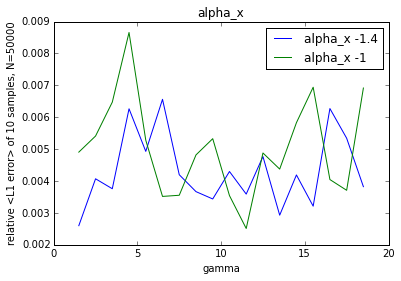

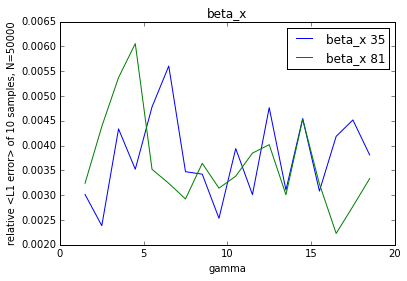

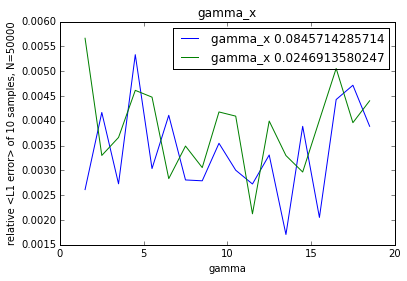

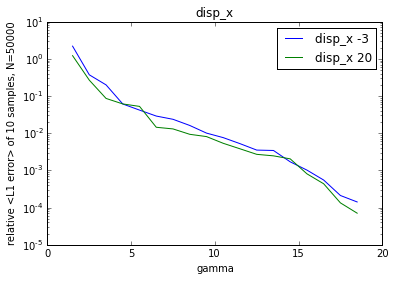

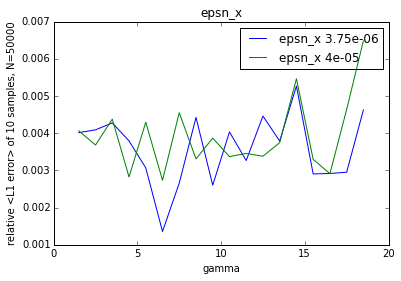

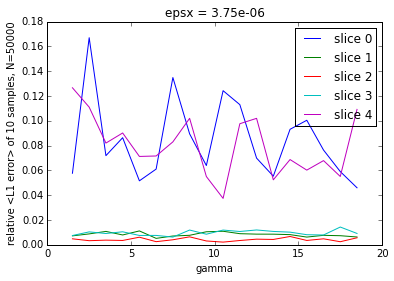

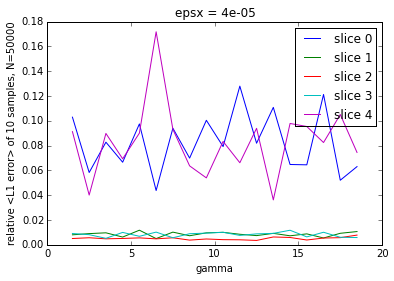

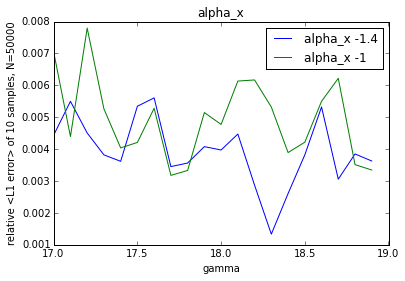

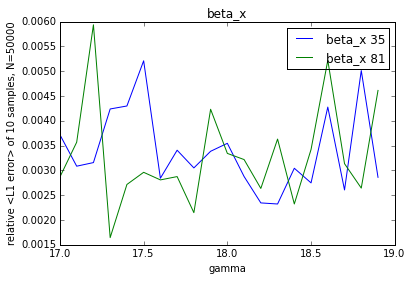

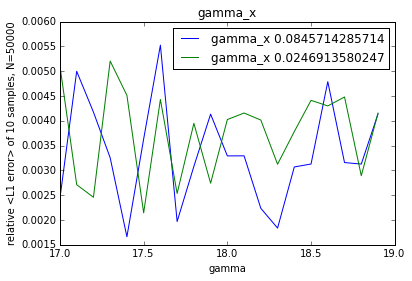

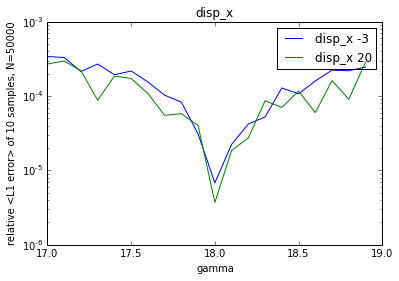

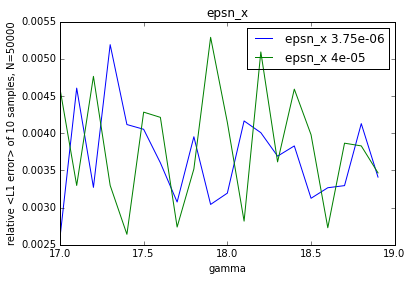

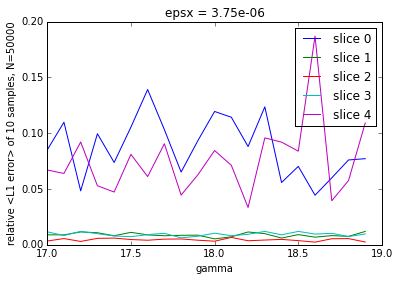

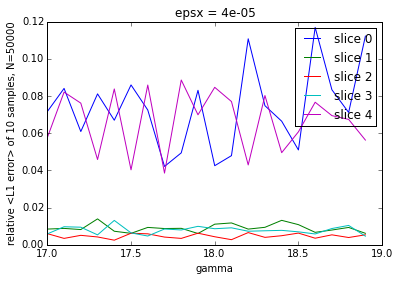

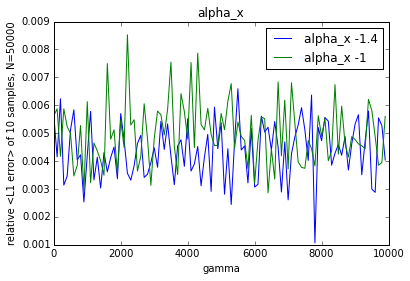

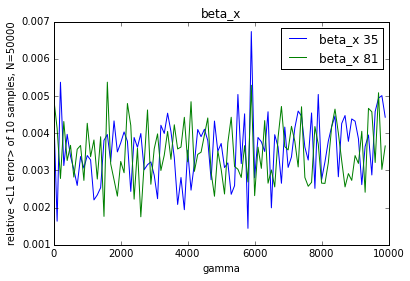

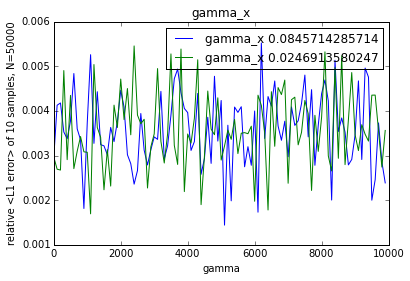

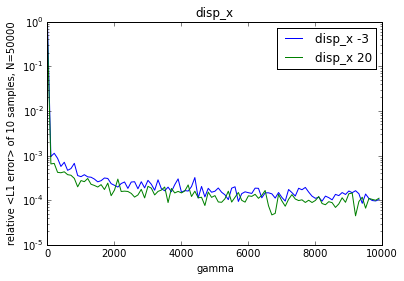

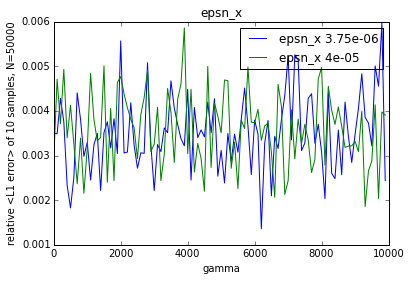

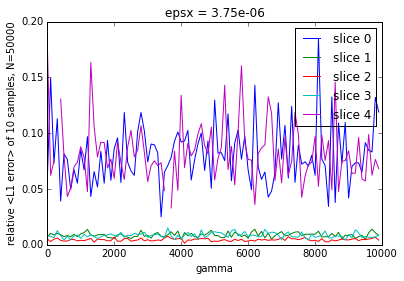

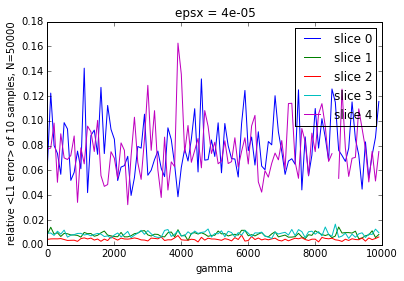

In [5]:
# Run this to test the parameter inference vs gamma
%matplotlib inline
np.random.seed(111)
plot_params_vs_gamma()

In [14]:
def test_transverse_and_longitudinal_map(n_macroparticles, linear_map, gamma = 3730.27):
    ax = np.array([-1.2, 2., 3.])
    ay = np.array([0.3, 2., 3.])
    bx = np.array([82., 90., 100.])
    by = np.array([45., 30, 80.])
    gx = (ax*ax + 1.) / bx
    gy = (ay*ay + 1.) / by
    dx = np.array([100, 100, 100])#np.array([0.5, 5.3, 0.3])
    dy = np.array([100, 100, 100])#np.array([0.2, -4.1, 2.09])
    segments = np.linspace(0., C, num=4)
    
    # generate a map with the given parameters
    trans_map = TransverseMap(C, segments, ax, bx, dx, ay, by, dy, Q_x, Q_y)
    map_ = [m for m in trans_map]
    
    # generate a bunch matched to the alpha, beta and d of the first segment
    b = generate_bunch(n_macroparticles, ax[0], ay[0], bx[0], by[0], linear_map, dx[0], dy[0], gamma=gamma)
    
    def my_long_map(beam):
        omega_0 = 2 * np.pi * beam.beta * c / C
        omega_s = omega_0 * Q_s
        dQs = 2 * np.pi * Q_s
        z_copy = beam.z.copy()
        dp_copy= beam.dp.copy()
        eta = alpha_0[0] - gamma**-2

        beam.z *= np.cos(dQs)
        beam.z -= eta * beam.beta * c / omega_s * dp_copy * np.sin(dQs)
        beam.dp *= np.cos(dQs)
        beam.dp += omega_s/(eta*beam.beta*c) *z_copy *np.sin(dQs)

    
    def print_parameters(b, it):
        it = it % 3 #to make sure that after the last segment you access the first segment's parameters
        print('alphax: ' + str(ax[it]) + ' <---> ' + str(b.alpha_Twiss_x()))
        print('alphay: ' + str(ay[it]) + ' <---> ' + str(b.alpha_Twiss_y()))
        print('betax: ' + str(bx[it]) + ' <---> ' + str(b.beta_Twiss_x()))
        print('betay: ' + str(by[it]) + ' <---> ' + str(b.beta_Twiss_y()))
        print('gammax: ' + str(gx[it]) + ' <---> ' + str(b.gamma_Twiss_x()))
        print('gammay: ' + str(gy[it]) + ' <---> ' + str(b.gamma_Twiss_y()))
        print('dispx: ' + str(dx[it]) + ' <---> ' + str(b.dispersion_x()))
        print('dispy: ' + str(dy[it]) + ' <---> ' + str(b.dispersion_y()))
        print('epsnx: ' + str(3.75e-6) + ' <---> ' + str(b.epsn_x()))
        print('epsny: ' + str(3.75e-6) + ' <---> ' + str(b.epsn_y()))
        print('epsnz: ' + 'TODO' + ' <---> ' + str(b.epsn_z()))
        print('\n')
    
    print_parameters(b, 0) # matched to the first segment
    #track and check parameters!
    nturns = 4
    for n in xrange(nturns):
        for it,m in enumerate(map_):
            m.track(b)
            print_parameters(b, it+1)
        my_long_map(b)
        print_parameters(b, 0) #check whether it is still correct after a longitudinal tracking!


            
    

In [15]:
def plot_phase_space(beam, direction):
    plt.figure()
    u = getattr(beam, direction[0])
    up = getattr(beam, direction[1])
    plt.scatter(u, up)
    minimum = min(min(u),min(up))
    maximum =  max(max(u), max(up))
    plt.ylim([minimum, maximum])
    plt.xlim([minimum, maximum])
    plt.xlabel(direction[0])
    plt.ylabel(direction[1])
    plt.show()

In [16]:
# Generate a bunch with the given optics and compare them to the statistically computed parameters
def compute_statistical_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=3000):
    b = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=gamma)
    gammax = (1. + alphax**2)/betax
    gammay = (1. + alphay**2)/betay
    print('Compare the nominal and the statistically computed quantities from the beam')
    print('nominal: <---> statistical:')
    print('alphax: ' + str(alphax) + ' <---> ' + str(b.alpha_Twiss_x()))
    print('alphay: ' + str(alphay) + ' <---> ' + str(b.alpha_Twiss_y()))
    print('betax: ' + str(betax) + ' <---> ' + str(b.beta_Twiss_x()))
    print('betay: ' + str(betay) + ' <---> ' + str(b.beta_Twiss_y()))
    print('gammax: ' + str(gammax) + ' <---> ' + str(b.gamma_Twiss_x()))
    print('gammay: ' + str(gammay) + ' <---> ' + str(b.gamma_Twiss_y()))
    print('dispx: ' + str(dispx) + ' <---> ' + str(b.dispersion_x()))
    print('dispy: ' + str(dispy) + ' <---> ' + str(b.dispersion_y()))

    

In [17]:
def plot_histogram(measurements, exact_value, title="Dummy"):
    plt.hist(measurements)
    plt.axvline(measurements.mean(), color='r', linestyle='dashed', linewidth=2)
    plt.axvline(exact_value, color='g', linewidth=2)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('# observations')
    m = mpatches.Patch(color='red', label='mean')
    ex = mpatches.Patch(color='green', label='input')

    plt.legend(handles=[m, ex])
    plt.show()


In [18]:
def compute_distribution_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=3000):
    nsamples = 100
    stat_betax = np.zeros(nsamples)
    stat_betay = np.zeros(nsamples)
    stat_alphax = np.zeros(nsamples)
    stat_alphay = np.zeros(nsamples)
    stat_dispx = np.zeros(nsamples)
    stat_dispy = np.zeros(nsamples)

    for i in xrange(nsamples):
        b = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy,gamma=gamma)
        stat_betax[i] = b.beta_Twiss_x()
        stat_betay[i] = b.beta_Twiss_y()
        stat_dispx[i] = b.dispersion_x()
        stat_dispy[i] = b.dispersion_y()
        stat_alphax[i] = b.alpha_Twiss_x()
        stat_alphay[i] = b.alpha_Twiss_y()
        
    plot_histogram(stat_betax, betax, 'beta_x')
    plot_histogram(stat_betay, betay, 'beta_y')
    plot_histogram(stat_alphax, alphax, 'alpha_x')
    plot_histogram(stat_alphay, alphay, 'alpha_y')
    plot_histogram(stat_dispx, dispx, 'disp_x')
    plot_histogram(stat_dispy, dispy, 'disp_y')

    plt.show()


In [19]:
# Basic simulation parameters
n_turns = 10
n_segments = 2
n_macroparticles = 100000

Q_x = 20.13
Q_y = 20.18
Q_s = 0.017

C = 6911.
R = C / (2.*np.pi)

alpha_0 = [0.00308]
long_map = LinearMap(alpha_0, C, Q_s)

mass: 1.672621777e-27
c**2: 8.98755178737e+16
E0: 1.50327748415e-07
Compare the nominal and the statistically computed quantities from the beam
nominal: <---> statistical:
alphax: 0.5 <---> 0.498485901967
alphay: -1.7 <---> -1.69453613961
betax: 90 <---> 90.0043352451
betay: 40 <---> 39.8699401972
gammax: 0.0138888888889 <---> 0.0138714228716
gammay: 0.09725 <---> 0.0971020450316
dispx: 4.3 <---> 4.29877974121
dispy: -3.0 <---> -3.00086085138


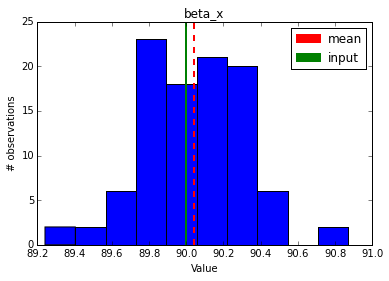

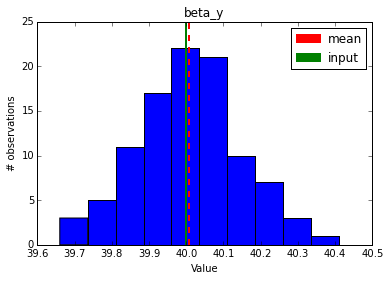

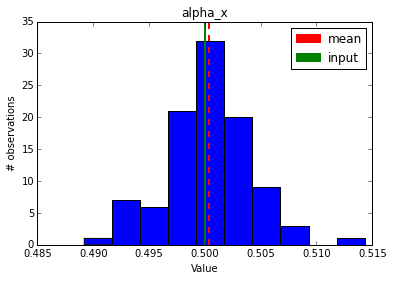

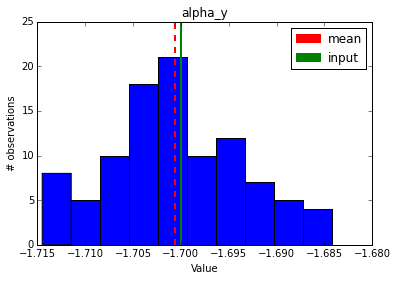

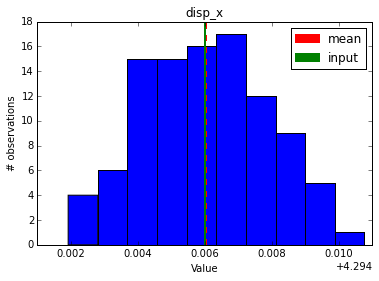

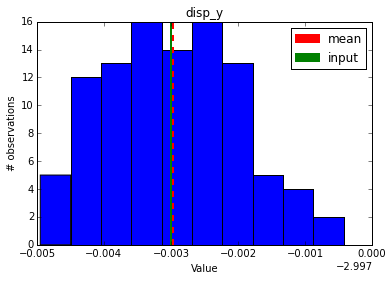

In [20]:
%matplotlib inline
alphax = 0.5
alphay = -1.7
betax = 90
betay = 40
dispx = 4.3
dispy = -3.
gamma = 1000
beam2 = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=gamma)
print('mass: ' + str(beam2.mass))
print('c**2: ' + str(c**2))
print('E0: ' + str(beam2.gamma*beam2.mass*c*c))
compute_statistical_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma)

compute_distribution_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma)


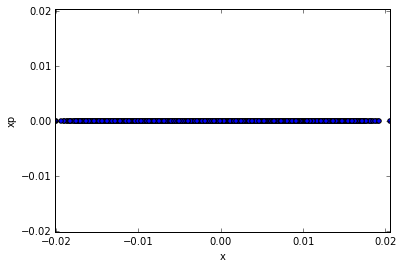

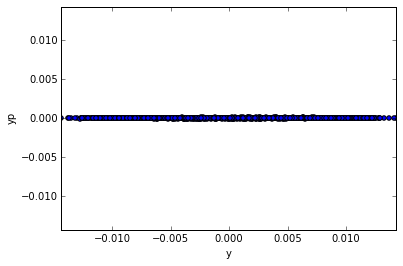

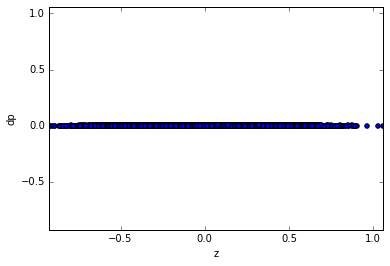

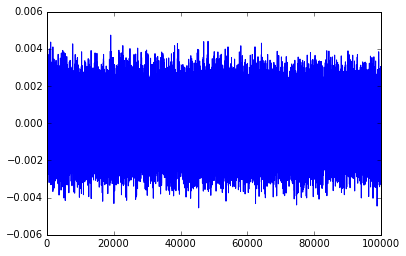

In [21]:
%matplotlib inline
plot_phase_space(beam2, ['x', 'xp'])
plot_phase_space(beam2, ['y', 'yp'])
plot_phase_space(beam2, ['z', 'dp'])
plt.plot(beam2.dp)
plt.show()

In [22]:
test_transverse_and_longitudinal_map(10000, long_map, 4000) 


*** PyHEADTAIL WARNING! Non-zero dispersion; ensure the beam has been "blown-up" accordingly upon creation!
alphax: -1.2 <---> -1.1941812503
alphay: 0.3 <---> 0.290588938591
betax: 82.0 <---> 81.8524039403
betay: 45.0 <---> 44.9994065012
gammax: 0.029756097561 <---> 0.0296395553678
gammay: 0.0242222222222 <---> 0.0240990274217
dispx: 100 <---> 100.003981552
dispy: 100 <---> 99.9964419059
epsnx: 3.75e-06 <---> 3.7604212434e-06
epsny: 3.75e-06 <---> 3.76168839829e-06
epsnz: TODO <---> 41.7544449962


alphax: 2.0 <---> 1.99558320289
alphay: 2.0 <---> 2.01462538031
betax: 90.0 <---> 89.9847263472
betay: 30.0 <---> 30.0845456346
gammax: 0.0555555555556 <---> 0.0553688667169
gammay: 0.166666666667 <---> 0.168149969238
dispx: 100 <---> 100.002318992
dispy: 100 <---> 100.001731124
epsnx: 3.75e-06 <---> 3.76042124168e-06
epsny: 3.75e-06 <---> 3.76168837997e-06
epsnz: TODO <---> 41.7544449962


alphax: 3.0 <---> 3.00987319164
alphay: 3.0 <---> 2.97656820383
betax: 100.0 <---> 100.212864014
beta